In [11]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/房地產實價登錄')
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras import Input
from keras import optimizers
from keras import layers
from keras.layers import BatchNormalization,Dropout,Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
### 1.匯入檔案 ###
'''
用 2023 年之前的資料預測 2023 年的房價
'''
df_realEstate = pd.read_csv('realEstate.csv', encoding = 'big5')

# 拆分成訓練集與測試集
df_train = df_realEstate[df_realEstate['交易年份'] < 2023]
df_test = df_realEstate[df_realEstate['交易年份'] >= 2023] # 還未刪除「總價元」(房價)欄位

# 確認數據數量
print('df_train:',len(df_train),'\ndf_test:',len(df_test),'\ndf_realEstate:',len(df_realEstate),
      '\nall:',len(df_train) + len(df_test))

# 訓練集資訊
print(df_train.info())

df_train: 287458 
df_test: 12376 
df_realEstate: 299834 
all: 299834
<class 'pandas.core.frame.DataFrame'>
Int64Index: 287458 entries, 0 to 299833
Data columns (total 72 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   建物現況格局-廳     287458 non-null  int64  
 1   建物現況格局-房     287458 non-null  int64  
 2   建物現況格局-衛     287458 non-null  int64  
 3   總價元          287458 non-null  float64
 4   總樓層數         287458 non-null  float64
 5   車位總價元        287458 non-null  float64
 6   電梯           287458 non-null  int64  
 7   主建物面積坪       287458 non-null  float64
 8   土地移轉總面積坪     287458 non-null  float64
 9   建物移轉總面積坪     287458 non-null  float64
 10  車位移轉總面積坪     287458 non-null  float64
 11  附屬建物面積坪      287458 non-null  float64
 12  陽台面積坪        287458 non-null  float64
 13  交易年份         287458 non-null  int64  
 14  建築完成年份       287458 non-null  float64
 15  屋齡           287458 non-null  float64
 16  其他位置         287458 non-null  int64  
 17

In [13]:
### 2.資料處理 ###

## 2.1標準化 ##
'''
針對數值型欄位進行標準化
'''
#df_realEstate.columns

cols_std = ['建物現況格局-廳', '建物現況格局-房', '建物現況格局-衛', '總樓層數', '車位總價元', '電梯', '主建物面積坪',
       '土地移轉總面積坪', '建物移轉總面積坪', '車位移轉總面積坪', '附屬建物面積坪', '陽台面積坪', '交易年份',
       '建築完成年份', '屋齡', '其他位置', '地下樓層', '低樓層', '中樓層', '高樓層','超高樓層']

df_train.loc[:, cols_std] = StandardScaler().fit_transform(df_train.loc[:, cols_std])
df_test.loc[:, cols_std] = StandardScaler().fit_transform(df_test.loc[:, cols_std])
df_train

<ipython-input-13-089a9b36ad26>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, cols_std] = StandardScaler().fit_transform(df_train.loc[:, cols_std])
<ipython-input-13-089a9b36ad26>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:, cols_std] = StandardScaler().fit_transform(df_test.loc[:, cols_std])
<ipython-input-13-089a9b36ad26>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new arra

,建物現況格局-廳,建物現況格局-房,建物現況格局-衛,總價元,總樓層數,車位總價元,電梯,主建物面積坪,土地移轉總面積坪,建物移轉總面積坪,...,鄉鎮市區_石門區,鄉鎮市區_萬華區,鄉鎮市區_萬里區,鄉鎮市區_蘆洲區,鄉鎮市區_貢寮區,鄉鎮市區_金山區,鄉鎮市區_雙溪區,縣市_台北市,建物型態_住宅大樓,建物型態_華廈
0,-1.113974,0.348847,-0.813515,14000000.0,-1.133249,-0.414261,-2.315435,0.272024,0.414583,-0.432229,...,0,0,0,0,0,0,0,1,0,0
1,-1.113974,-0.590392,-0.813515,19000000.0,-1.133249,-0.414261,-2.315435,0.401317,0.352296,-0.420797,...,0,0,0,0,0,0,0,1,0,0
2,0.512073,0.348847,0.497620,28000000.0,-1.275594,-0.414261,-2.315435,0.935845,1.217101,-0.109312,...,0,0,0,0,0,0,0,1,0,0
3,0.512073,-0.590392,-0.813515,21500000.0,-0.990904,-0.414261,0.431884,-0.424793,0.398110,-0.234324,...,0,0,0,0,0,0,0,1,0,1
4,0.512073,0.348847,0.497620,12100000.0,-1.275594,-0.414261,-2.315435,-1.919368,0.367739,-0.568795,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299829,0.512073,0.348847,0.497620,19960000.0,-0.279181,1.130271,0.431884,-0.247350,0.273537,0.299036,...,0,0,0,0,0,0,0,0,1,0
299830,-1.113974,-1.529631,-0.813515,10780000.0,0.290198,0.287799,0.431884,-1.251392,-0.855857,-0.862334,...,0,0,0,0,0,0,0,0,1,0
299831,-1.113974,-0.590392,-0.813515,8800000.0,0.005509,0.287799,0.431884,-0.785544,-0.490889,-0.579735,...,0,0,0,0,0,0,0,0,1,0
299832,-1.113974,0.348847,0.497620,19930000.0,0.290198,2.113155,0.431884,-0.633764,-0.362712,0.059952,...,0,0,0,0,0,0,0,0,1,0


In [14]:
## 2.2資料拆分 ##
'''
將資料拆成應變數與自變數以放入預測模型中
'''
train_targets = df_train["總價元"]
train_data = df_train.drop(columns = ["總價元"])

# 訓練集拆分驗證集
'''
將訓練集拆分成 8:2 ，20%作為驗證集
'''
X_train, X_validation, Y_trian, Y_validation = train_test_split(train_data, train_targets, test_size = 0.2, random_state = 0)



In [15]:
### 3.建立神經網路模型 ###

## 3.1 神經網路模型 ##

def model():
    model = Sequential()

    #輸入層
    model.add(Input(shape = (X_train.shape[1],)))

    #隱藏層
    model.add(layers.Dense(1024, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(1024, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(layers.Dense(1024, activation = 'relu'))
    model.add(Dropout(0.5))

    #輸出層
    model.add(layers.Dense(1, activation = 'linear'))

    # 優化器
    adam = optimizers.Adam(learning_rate = 0.0125)
    model.compile(optimizer = adam, loss = 'mae')

    return model

# 模型配適
model = model()

history = model.fit(X_train, Y_trian,                 # 訓練集
           validation_data = [X_validation, Y_validation], # 測試集
           epochs = 100,                   # 迭代次數
           batch_size = 256,                 # 每次迭代的批次大小
           verbose = 1)                   # 進度條模式


Epoch 1/100
899/899 [==============================] - 7s 7ms/step - loss: 3711936.7500 - val_loss: 2878824.2500
Epoch 2/100
899/899 [==============================] - 5s 5ms/step - loss: 2947782.5000 - val_loss: 2748385.7500
Epoch 3/100
899/899 [==============================] - 4s 5ms/step - loss: 2833389.5000 - val_loss: 2611910.5000
Epoch 4/100
899/899 [==============================] - 5s 5ms/step - loss: 2765370.0000 - val_loss: 2494282.7500
Epoch 5/100
899/899 [==============================] - 5s 5ms/step - loss: 2706499.2500 - val_loss: 2436233.5000
Epoch 6/100
899/899 [==============================] - 4s 5ms/step - loss: 2662542.7500 - val_loss: 2459509.0000
Epoch 7/100
899/899 [==============================] - 5s 5ms/step - loss: 2629506.0000 - val_loss: 2595290.7500
Epoch 8/100
899/899 [==============================] - 5s 6ms/step - loss: 2599416.7500 - val_loss: 2434119.5000
Epoch 9/100
899/899 [==============================] - 4s 5ms/step - loss: 2573295.2500 - val_lo

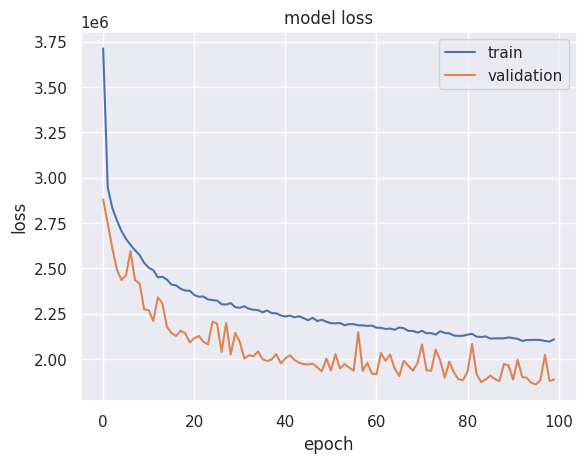

In [16]:
# 損失函數
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper right')
plt.show()

In [17]:
# 模型預測
X_test = df_test.drop(columns=["總價元"]) #刪除SalePrice這行
test_pred = model.predict(X_test,verbose=2) #括號內填入要預測的資料
test_real = df_test["總價元"]

# 預測結果
'''
針對迴歸結果使用判定係數進行比較，數值結果來說表現並不算好
或許可以考慮將解釋變數再進行篩選，或是重新設計模型
'''
r2 = r2_score(test_pred,test_real)
r2



387/387 - 1s - 616ms/epoch - 2ms/step


0.6113743811119228

In [18]:
## 3.2 隨機森林模型 ##
model_rf = RandomForestRegressor(n_estimators = 100, # 樹的數量
                  random_state = 0)
model_rf.fit(X_train, Y_trian)

RandomForestRegressor(random_state=0)

In [19]:
# 模型預測
X_test = df_test.drop(columns = ["總價元"])
test_pred = model_rf.predict(X_test)
test_real = df_test["總價元"]

# 預測結果
'''
明顯表現比本次設計的神經網路模型來的更好
'''
r2 = r2_score(test_pred,test_real)
r2

0.8849760464496715